Question7 - Zoom images by a given factor

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, csv

im01small.png        -> im01.png   | nSSD(nearest)=0.005855  nSSD(bilinear)=0.004974


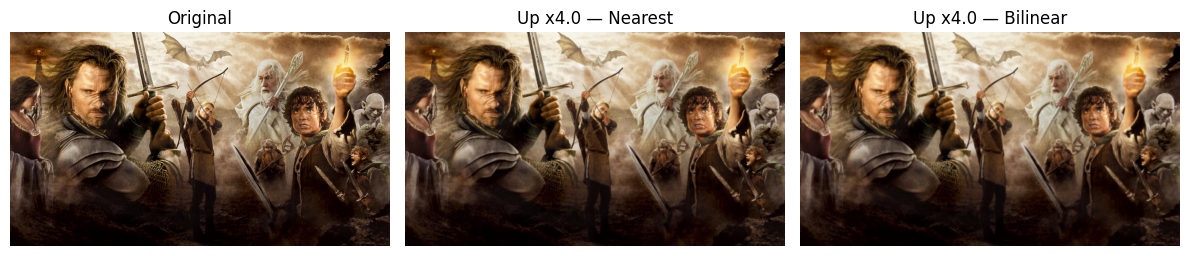

im02small.png        -> im02.png   | nSSD(nearest)=0.002098  nSSD(bilinear)=0.001461


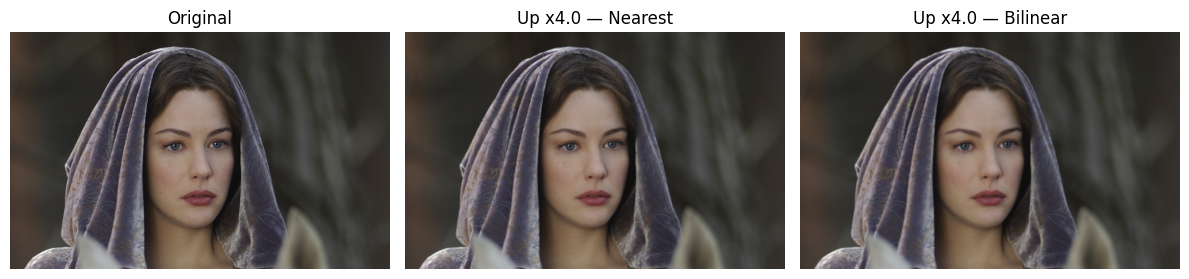

im03small.png        -> im03.png   | nSSD(nearest)=0.003779  nSSD(bilinear)=0.002814


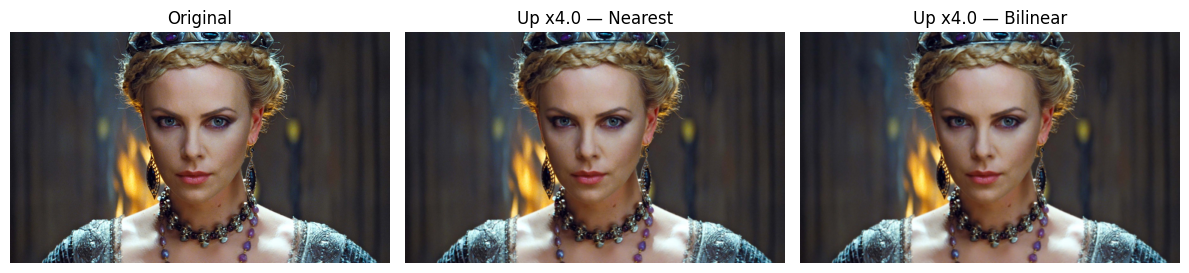

taylor_small.jpg     -> taylor.jpg | nSSD(nearest)=0.002842  nSSD(bilinear)=0.002707


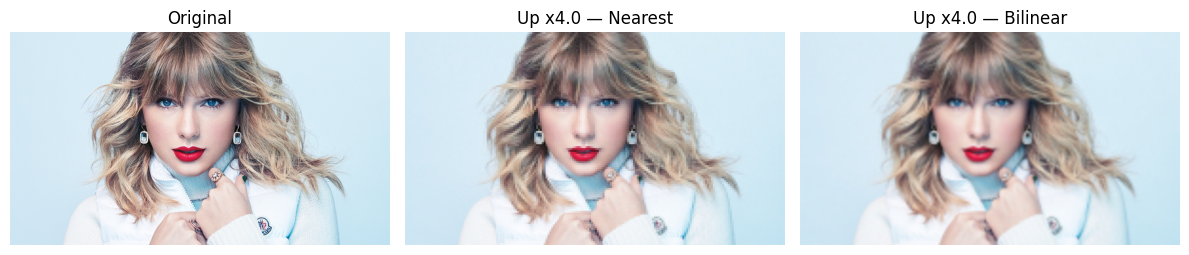

taylor_very_small.jpg -> taylor.jpg | nSSD(nearest)=0.005697  nSSD(bilinear)=0.005350


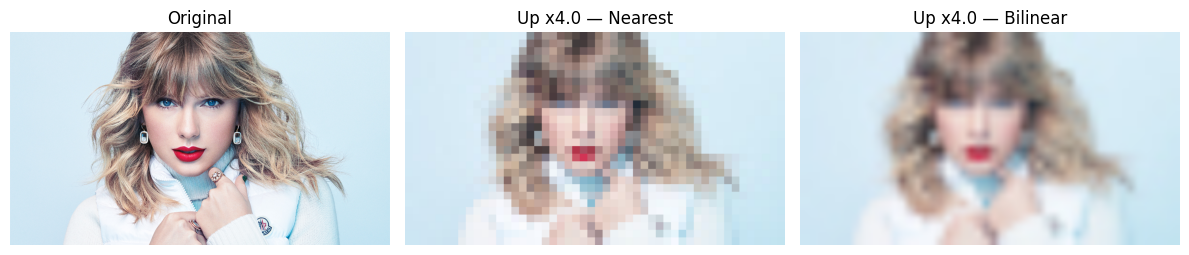

In [2]:
data_dir       = Path("../data/a1q8images")
output_dir     = Path("../data/output_images")
output_dir.mkdir(parents=True, exist_ok=True)
summary_csv    = output_dir / "q7_nssd_summary.csv"

pairs = [
    ("im01small.png", "im01.png"),
    ("im02small.png", "im02.png"),
    ("im03small.png", "im03.png"),
    ("taylor_small.jpg", "taylor.jpg"),
    ("taylor_very_small.jpg", "taylor.jpg"),
]

# helpers
def imread_rgb(path: Path):
    img_bgr = cv.imread(str(path), cv.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(path)
    return cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

def to_gray_uint8(img_rgb):
    return cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)

def normalized_ssd(a: np.ndarray, b: np.ndarray) -> float:
    """Energy-normalized SSD in [0,1): sum((a-b)^2)/(sum(a^2)+sum(b^2)+eps)."""
    a = a.astype(np.float32); b = b.astype(np.float32)
    if a.shape != b.shape:
        raise ValueError(f"nSSD shape mismatch: {a.shape} vs {b.shape}")
    ssd   = np.sum((a - b) ** 2)
    denom = np.sum(a ** 2) + np.sum(b ** 2) + 1e-9
    return float(ssd / denom)

def zoom(img: np.ndarray, s: float, method: str = "nearest") -> np.ndarray:
    """
    Scale image by factor s (0 < s <= 10).
    method: 'nearest' or 'bilinear'
    Works for HxW or HxWxC (RGB).
    """
    if not (0 < s <= 10):
        raise ValueError("s must be in (0,10].")
    H, W = img.shape[:2]
    C    = 1 if img.ndim == 2 else img.shape[2]
    outH, outW = int(round(H * s)), int(round(W * s))

    # build target grid and inverse-map to source pixel centers
    yy, xx = np.meshgrid(np.arange(outH), np.arange(outW), indexing="ij")
    sy = (yy + 0.5) / s - 0.5
    sx = (xx + 0.5) / s - 0.5
    sy = np.clip(sy, 0, H - 1)
    sx = np.clip(sx, 0, W - 1)

    if method == "nearest":
        ny = np.rint(sy).astype(np.int32)
        nx = np.rint(sx).astype(np.int32)
        return img[ny, nx] if C > 1 else img[ny, nx].astype(img.dtype)

    if method == "bilinear":
        y0 = np.floor(sy).astype(np.int32); x0 = np.floor(sx).astype(np.int32)
        y1 = np.clip(y0 + 1, 0, H - 1);     x1 = np.clip(x0 + 1, 0, W - 1)
        wy = sy - y0; wx = sx - x0
        w00 = (1 - wy) * (1 - wx)
        w01 = (1 - wy) * wx
        w10 = wy * (1 - wx)
        w11 = wy * wx
        # fetch neighbors (float math)
        if C == 1:
            Ia = img[y0, x0].astype(np.float32)
            Ib = img[y0, x1].astype(np.float32)
            Ic = img[y1, x0].astype(np.float32)
            Id = img[y1, x1].astype(np.float32)
            out = Ia*w00 + Ib*w01 + Ic*w10 + Id*w11
        else:
            Ia = img[y0, x0, :].astype(np.float32)
            Ib = img[y0, x1, :].astype(np.float32)
            Ic = img[y1, x0, :].astype(np.float32)
            Id = img[y1, x1, :].astype(np.float32)
            out = Ia*w00[..., None] + Ib*w01[..., None] + Ic*w10[..., None] + Id*w11[..., None]
        return np.clip(out, 0, 255).astype(img.dtype)

    raise ValueError("method must be 'nearest' or 'bilinear'")

# evaluation (s = 4) 
rows = [["small", "original", "nSSD_nearest", "nSSD_bilinear"]]
s = 4.0

for small_name, orig_name in pairs:
    sp = data_dir / small_name
    op = data_dir / orig_name
    if not sp.exists() or not op.exists():
        print(f"Skip (missing): {small_name} / {orig_name}")
        continue

    small = imread_rgb(sp)
    orig  = imread_rgb(op)
    up_nn = zoom(small, s=s, method="nearest")
    up_bl = zoom(small, s=s, method="bilinear")

    # Ensure sizes match original exactly (safety in case of rounding)
    H, W = orig.shape[:2]
    up_nn = cv.resize(up_nn, (W, H), interpolation=cv.INTER_NEAREST)
    up_bl = cv.resize(up_bl, (W, H), interpolation=cv.INTER_LINEAR)

    # nSSD on grayscale
    nssd_nn = normalized_ssd(to_gray_uint8(up_nn), to_gray_uint8(orig))
    nssd_bl = normalized_ssd(to_gray_uint8(up_bl), to_gray_uint8(orig))
    rows.append([small_name, orig_name, f"{nssd_nn:.6f}", f"{nssd_bl:.6f}"])
    print(f"{small_name:20s} -> {orig_name:10s} | nSSD(nearest)={nssd_nn:.6f}  nSSD(bilinear)={nssd_bl:.6f}")

    # Save a side-by-side comparison image
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(orig);  plt.title("Original");           plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(up_nn); plt.title(f"Up x{s} — Nearest"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(up_bl); plt.title(f"Up x{s} — Bilinear");plt.axis("off")
    plt.tight_layout()
    trip_path = output_dir / f"q7_{Path(small_name).stem}_grid.png"
    plt.savefig(str(trip_path), dpi=150); plt.show()

In [3]:
# Save summary CSV
with open(summary_csv, "w", newline="") as f:
    csv.writer(f).writerows(rows)

print("Saved:", summary_csv)

Saved: ..\data\output_images\q7_nssd_summary.csv
